In [4]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
from tld import get_fld
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from scipy.ndimage import gaussian_filter1d

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

blue_col   = "#3498db"
red_col    = "#e74c3c"
green_col  = "#2ecc71"
orange_col = "#ff9214"

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)

Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [5]:
def convert(x):
    try:
        return get_fld(x)
    except:
        return ""

In [18]:
df_sources = pd.read_csv("/home/fanfou/Panorama/scripts/4imn_de.csv", sep=",")
df_sources['website'] = df_sources['website'].map(lambda x: get_fld(x))
df_sources.head()

,name,website,twitter,location
0,Bild,bild.de,"['https://twitter.com/BILD', 'https://twitter.com/bild']",Hamburg
1,Die Welt,welt.de,['https://twitter.com/welt'],Berlin
2,Die Zeit,zeit.de,['https://twitter.com/zeitonline'],Hamburg
3,Süddeutsche Zeitung,sueddeutsche.de,"['https://twitter.com/SZ', 'https://twitter.com/sz']",München
4,Frankfurter Allgemeine Zeitung,faz.net,['https://twitter.com/faznet'],Frankfurt am Main


In [19]:
path_to_json = "/mnt/datastore/data/medias/de/"

list_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
df = pd.DataFrame()

for fili in list_files:
    with open(os.path.join(path_to_json, fili), "r") as inputjson:
      
        tmp = pd.read_json(inputjson)
        try:
            tmp['root_domain'] = tmp['permalink'].map(lambda x: convert(x))
            tmp = tmp[tmp['root_domain'].isin(df_sources['website'])]
            tmp['published'] = pd.to_datetime(tmp['published'])
            searchfor = ['coronavirus', 'covid', 'virus', 'pandemic']
            tmp = tmp[~tmp.main.isna()]
            tmp = tmp[tmp.main.str.lower().str.contains('|'.join(searchfor))]
            df = df.append(tmp)
        except: 
            print(fili)




df.count()                         

213.json


publisher                    119
main                         158
permalink                    158
permalink_redirect_domain    158
lang                         158
published                    158
root_domain                  158
dtype: int64

In [20]:
df.count() 

publisher                    76241
main                         81316
permalink                    81316
permalink_redirect_domain    81316
lang                         81316
published                    81316
root_domain                  81316
dtype: int64

In [21]:
df_filt_by_date = df.resample('D', on='published').count()

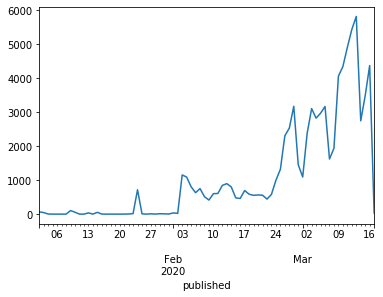

In [22]:
df_filt_by_date['permalink'].plot()

In [23]:
df_filt_by_date['permalink'].to_csv("/mnt/datastore/data/medias/media_allemagne.csv", header=None)

In [24]:
df_filt_by_date['permalink']

published
2020-01-02 00:00:00+00:00      65
2020-01-03 00:00:00+00:00      45
2020-01-04 00:00:00+00:00       2
2020-01-05 00:00:00+00:00       0
2020-01-06 00:00:00+00:00       0
2020-01-07 00:00:00+00:00       0
2020-01-08 00:00:00+00:00       0
2020-01-09 00:00:00+00:00     105
2020-01-10 00:00:00+00:00      55
2020-01-11 00:00:00+00:00       0
2020-01-12 00:00:00+00:00       0
2020-01-13 00:00:00+00:00      36
2020-01-14 00:00:00+00:00       1
2020-01-15 00:00:00+00:00      52
2020-01-16 00:00:00+00:00       1
2020-01-17 00:00:00+00:00       0
2020-01-18 00:00:00+00:00       0
2020-01-19 00:00:00+00:00       0
2020-01-20 00:00:00+00:00       0
2020-01-21 00:00:00+00:00       1
2020-01-22 00:00:00+00:00       3
2020-01-23 00:00:00+00:00      15
2020-01-24 00:00:00+00:00     717
2020-01-25 00:00:00+00:00       8
2020-01-26 00:00:00+00:00       0
2020-01-27 00:00:00+00:00       9
2020-01-28 00:00:00+00:00       1
2020-01-29 00:00:00+00:00      12
2020-01-30 00:00:00+00:00       8
2020

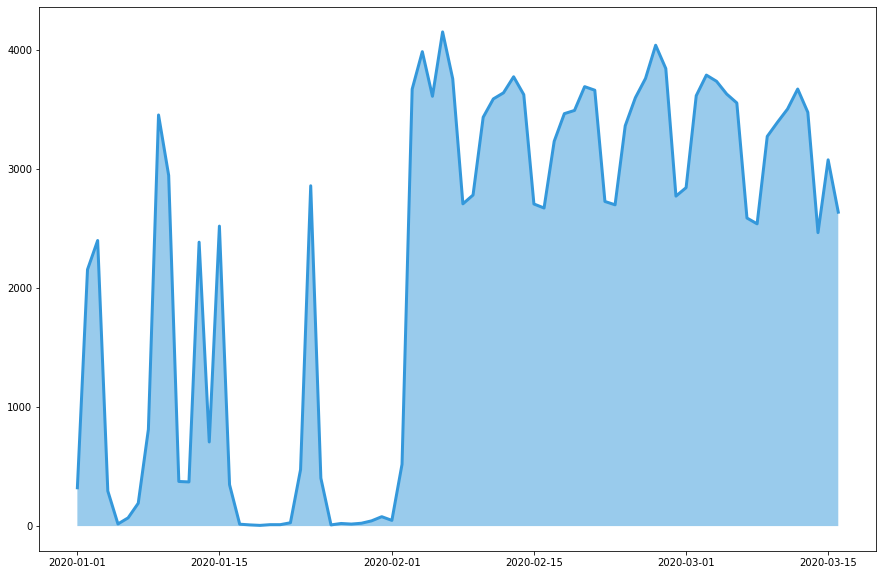

In [13]:
from scipy.ndimage.filters import gaussian_filter1d

plt.figure(figsize=(15,10))
signal = gaussian_filter1d(df_filt_by_date['permalink'], sigma=.5)
plt.plot(df_filt_by_date.index.values,signal,  color=blue_col, linewidth=3)
plt.fill_between(df_filt_by_date.index.values,signal, facecolor=blue_col, alpha=0.5)
plt.grid(False)